# COGS 108 - Final Project 

# Overview

In this data analysis project, I utilize data retrieved from previous health inspections performed in North Carolina (primarily the Raleigh area) on food establishments to discover whether or not repeated violations is a sign of a clean food establishment. I utilized a unique ID associated to a restauant from two data sets. From the first I also retrieved a boolean value as to whether there are repeated violations from that restaurant, and from the second I retrieved the cleanliness scores of the restaurants with their latest health inspection (score, and number of critical/non-critical violations). I split the cleanliness scoring variables into two sets that differ in terms of repeated violations; as a result, exploratory data analysis along with t-test procedures confirm that repeated violations represents a statistically higher chance of that establishment having a lower cleanliness score.

# Name & PID

- Name: Mazin Abubeker
- PID: A13517916

# Research Question

Do food establishments that have repeated violations on their record (as opposed to those who have no repeated violations) have a significantly lower overall health inspection score (in terms of score and number of overall violations)?

## Background and Prior Work

My original project proposal consisted of analyzing the ABC grade-card system for health safety standards, but I have shifted my research question to focus more on utilizing the data given to us, because I would really like to work with a specific piece of information that is given to us in these datasets (repeated violations).

References (include links):
- 1) https://pubmed.ncbi.nlm.nih.gov/16779998/

This research article in fact covers this exact topic. These researchers took a sample of restaurants and checked for the amount of repeated violations during health inspections for restaurants that were both "high-threat" and "medium-threat" in terms of health safety standards. What was found was that the "high-threat" restaurants were indeed found to carry many more repeated violations than the "medium-threat" restaurant, which leads me to believe I may find a similar result in this data set.

- 2) https://dchealth.dc.gov/service/understanding-food-establishment-inspections

This article provides a more general sense of understanding for how these establishments function in terms of their threat level, and how that can be modulated due to things occuring during the health inspection. It is noted in this article that "repeated deficiencies" (seperate, repeated instances of not meeting a required health standard) has a big effect on the restaurants threat level. I believe this gives me some confidence in my hypothesis for this research project. 

# Hypothesis


I believe that food establishments with no record of repeated health safety violations recieve health inspection scores that are significantly higher than food establishments with a record of repeated health safety violations.

# Dataset(s)

Dataset Name: inspections.csv

Link to the dataset: [Provided for us in data.zip]

Number of observations: 18,466

Summary: This dataset represents a list of unique food establishments, with some of it's information, along with the latest health inspection scores (and further information about the inspection such as number of violations).

----

Dataset Name: violations.csv

Link to the dataset: [Provided for us in data.zip]

Number of observations: 189,802

Summary: This dataset represents a list of all available health inspection violations from the food establishments in inspections.csv. Each row represents a single violation that contains information about the violation such as the violation code, the establishment that incurred the violation, and if it is a repeated violation by that establishment.

----

I plan on associating the datasets together on the common feature 'hsisid', which represents a unique identifier for the food establishmnt. This identifier is unique in inspections.csv, but appears multiple times in violations.csv, since each violation (for each health inspection) adds a new row to that data set, with the same unique establishment identifier.


# Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

# Data Cleaning

First I'd like to clean up the inspections file. 

Before fixing any values that may be incosistent or not preferrable, I remove all of the columns that I do not need from the dataset with a single line of code. Then, once I have the four columns that I am interested in, I used 'isnull()' to detect for null values. Thankfully, there were a total of zero null values in the entire table of interest, so I did not have to take care of any null situations.

Next, I want to confirm that the data types are in the format that would be easiest for me to use through 'dtypes'. I expected (and wanted) an integer for the id, and two violation counts, and a float for the score. Thankfully, all of the datatypes seem to be exactly how I expect, so nothing further needs to be done here.


In [2]:
inspections = pd.read_csv('inspections.csv')
inspections = inspections[['hsisid', 'score', 'num_critical', 'num_non_critical']]
inspections.isnull().sum() # Evaluates to zero for all columns
inspections.dtypes

hsisid                int64
score               float64
num_critical          int64
num_non_critical      int64
dtype: object

Next, I'd like to clean up the violations file. This is a *massive* file (relatively speaking, 80MB), so I would definitely like to remove any information to speed up data processing. Thankfully, the majority of the data stored in this file is in a column that I do not need.

First, I removed all of the columns that I do not need from this dataset. Then, I checked for null values in the remaining data set. There were no null values in the hsisisd column, but many in violationtype. To solve this, since we only care about whether the value of violationtype is 'R' or not, we can simply set all null values to any other value (I chose 'CDI' for the sake of consistency).

In [3]:
violations = pd.read_csv('violations.csv')
violations = violations[['hsisid', 'violationtype']]
violations.isnull().sum() # Previous to filling NaN values

hsisid               0
violationtype    94639
dtype: int64

In [4]:
violations['violationtype'] = violations['violationtype'].fillna('CDI')
violations.isnull().sum() # After filling NaN values

hsisid           0
violationtype    0
dtype: int64

# Data Analysis & Results

Before any real analysis can take place, I first made sure that there were no outliers in my data. With the data that I am utiliziing, there are 4 potential places a data outlier - score, num_violations, and num_critical_violations. 

I did not want to remove any outliers from the number of violations (both critical and noncritical) because of what that data represents. The maximum of the data is 33 (33 violations), which is a reasonable (although high) and very realistic number. We want to measure health safety, so keeping this number in the data set (a bad restaurant) is necessary to give us information about how those bad scores reflect on repeated violations.

Additionally, the range of over 99% of the dataset's violations is 20, so 33 isn't really an 'outlier' (since we start at 0 and such a small relative number wont skew our results significantly).

Since the score has a limited range of 100%, and it directly depends on the violations themself, I do not believe the score needs to be searched for outliers either.

In [5]:
print(inspections['num_critical'].max(), inspections['num_non_critical'].max())

23 33


After confirming that I do not need to worry about outliers, I now want to split the data into the two groups I want to compare (food establishments who do/do not have repeated violations in their past). I then ensured that the data types were correct for each respective feature.

In [6]:
goodInspections = pd.DataFrame(columns=['hsisid', 'score', 'num_critical', 'num_non_critical'])
badInspections = pd.DataFrame(columns=['hsisid', 'score', 'num_critical', 'num_non_critical'])

index = 0
for id in inspections['hsisid']:
    violationHistory = []
    for curViolation in violations[violations.hsisid == id]['violationtype']:
        violationHistory.append(curViolation)
    if 'R' in violationHistory:
        badInspections = badInspections.append({'hsisid': id, 'score': inspections.iloc[index, 1], 'num_critical': inspections.iloc[index, 2], 'num_non_critical': inspections.iloc[index, 3]}, ignore_index=True)
    else:
        goodInspections = goodInspections.append({'hsisid': id, 'score': inspections.iloc[index, 1], 'num_critical': inspections.iloc[index, 2], 'num_non_critical': inspections.iloc[index, 3]}, ignore_index=True)
    index += 1

In [7]:
goodInspections['hsisid'] = goodInspections['hsisid'].astype(int)
goodInspections['num_critical'] = goodInspections['num_critical'].astype(int)
goodInspections['num_non_critical'] = goodInspections['num_non_critical'].astype(int)

badInspections['hsisid'] = badInspections['hsisid'].astype(int)
badInspections['num_critical'] = badInspections['num_critical'].astype(int)
badInspections['num_non_critical'] = badInspections['num_non_critical'].astype(int)

badInspections

,hsisid,score,num_critical,num_non_critical
0,4092013748,96.0,9,7
1,4092014046,98.0,0,11
2,4092015191,97.0,4,8
3,4092016122,99.0,2,3
4,4092021513,97.0,2,4
...,...,...,...,...
15933,4092021142,93.0,6,13
15934,4092110100,97.0,2,3
15935,4092110487,96.0,3,4
15936,4092300177,99.0,1,2


Now, we have two dataframes that both have the same format of inspections.csv. goodInspections contains all of the inspections with establishments with repeated violations, and badInspections contains all of the inspections for establishments with no repeated violations.

In [8]:
print(goodInspections.shape[0], badInspections.shape[0])

2528 15938


Let's perform some exploratory analysis now that we have our data in the form we want. First, I'd like to plot histograms of the score values that each of the restaurants' inspection received, but on seperate charts for our 'good' and 'bad' inspections.

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Score Distribution for Good Restaurants')

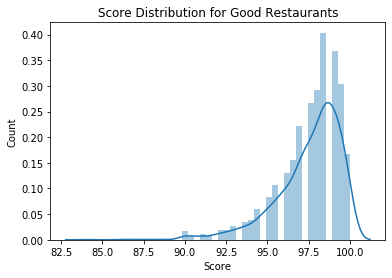

In [9]:
# plt.hist(goodInspections['score'], bins=100, label="Score")
plot1 = sns.distplot(goodInspections['score'])
plot1.set_ylabel('Count')
plot1.set_xlabel('Score')
plot1.set_title('Score Distribution for Good Restaurants')

Text(0.5, 1.0, 'Score Distribution for Bad Restaurants')

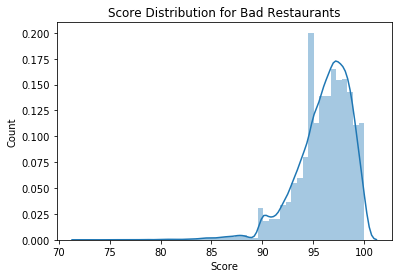

In [10]:
plot2 = sns.distplot(badInspections['score'])
plot2.set_ylabel('Count')
plot2.set_xlabel('Score')
plot2.set_title('Score Distribution for Bad Restaurants')

Our first plot shows a distribution plot of the score for restaurants with no previous repeated violations.

Our second plot shows a distribution plot of the score for restaurants with previous repeated violations.

Before we continue, we should make sure these are as normal as they seem, with a normal test.

In [11]:
pk1, tk1 = normaltest(goodInspections['score'].values)
pk2, tk2 = normaltest(goodInspections['num_critical'].values)
pk3, tk3 = normaltest(goodInspections['num_non_critical'].values)
pk4, tk4 = normaltest(badInspections['score'].values)
pk5, tk5 = normaltest(badInspections['num_critical'].values)
pk6, tk6 = normaltest(badInspections['num_non_critical'].values)

# We are using a t-value threshold of 0.01

if tk1 < .01 and tk2 < .01 and tk3 < .01 and tk4 < .01 and tk5 < .01 and tk6 < .01:
    print("All distributions look normal.")
else:
    print("Not all distributions look normal. Try again!")

All distributions look normal.


Perfect.

At first look, the plots look quite similar. Visually we see a very high average/mean score, around the >95% range, and they both follow a normal distribution around their median. Although, with a closer look, the median of the first graph seems to be in the middle of 97.5 and 100 (98.75), and the median of the second graph seems to be in the middle of 95 and 100 (about 97). Although this is only a difference of two percentage points, considering this is an estimated median and considering that almost all of the data points lie between 90 and 100, 2 percentage points is 20% of the range of almost the entire data set, which is very significant, so we should definitely continue.

Next, I will do the same but with the number of violations.

Text(0.5, 1.0, 'Non Critical Violation Distribution for Good Restaurants')

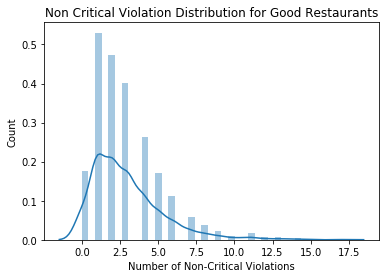

In [12]:
plot3 = sns.distplot(goodInspections['num_non_critical'])
plot3.set_ylabel('Count')
plot3.set_xlabel('Number of Non-Critical Violations')
plot3.set_title('Non Critical Violation Distribution for Good Restaurants')

Text(0.5, 1.0, 'Non Critical Violation Distribution for Bad Restaurants')

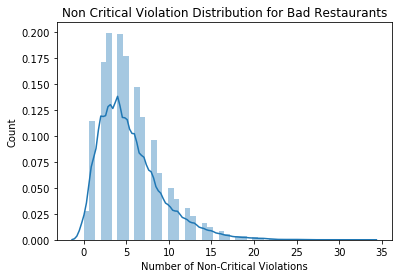

In [16]:
plot4 = sns.distplot(badInspections['num_non_critical'])
plot4.set_ylabel('Count')
plot4.set_xlabel('Number of Non-Critical Violations')
plot4.set_title('Non Critical Violation Distribution for Bad Restaurants')

Looks can be deceiving here! Although they look idential, we must realize that the axis at the bottom is doubled, meaning, that we expect *approximately* double the number of violations for a given restaurant with repeated violations relative to that of a given restaurant with no repeated violations. The difference between the two, relative to the range, isn't too significant, but it's interesting enough to continue on.

Finally, I'd like to perform a t-test analysis on the distributions from all three columns (score, number of critical violations, and number of noncritical violations). With this t-test I will retrieve a p-value with whether or not there is a statistically significant difference between two distributions. I will be using a value of 0.01 for my p-value threshold.

In [14]:
t1, p1 = ttest_ind(goodInspections['score'], badInspections['score'])
t2, p2 = ttest_ind(goodInspections['num_critical'], badInspections['num_critical'])
t3, p3 = ttest_ind(goodInspections['num_non_critical'], badInspections['num_non_critical'])

if p1 < .01:
    print("The difference between the overall scores are statistically significant!")
else:
    print("The difference between the overall scores are not statistically significant.")
    
if p2 < .01:
    print("The difference between the number of critical violations are statistically significant!")
else:
    print("The difference between the number of critical violations are not statistically significant.")

if p3 < .01:
    print("The difference between the number of non-critical violations are statistically significant!")
else:
    print("The difference between the number of non-critical violations are not statistically significant.")

The difference between the overall scores are statistically significant!
The difference between the number of critical violations are statistically significant!
The difference between the number of non-critical violations are statistically significant!


Huzzah! It seems that all three of the variables we chose to represent sanitation levels are statistically significant between restaurants that have no repeated violations and restaurants that do. This tells us that these two distributions have a factor (we assume to be what we split the dataset by) has a significant weight on predicting the cleanliness of a food establishment.


Here are the descriptions of how the mean and median differ from set to set, so we can confirm that the statistical difference is in the direction that we expected. We can see that the mean score goes up with no repeated violations, and the mean violations (for both) nearly *halve* in size! Now thats significant.

In [15]:
print("Score:")
print("Repeated Violations Median: " + str(badInspections['score'].mean()) + "  No Repeated Violations Median: " + str(goodInspections['score'].mean()))
print("Critical Violations:")
print("Repeated Violations Median: " + str(badInspections['num_critical'].mean()) + "  No Repeated Violations Median: " + str(goodInspections['num_critical'].mean()))
print("Non-Critical Violations:")
print("Repeated Violations Median: " + str(badInspections['num_non_critical'].mean()) + "  No Repeated Violations Median: " + str(goodInspections['num_non_critical'].mean()))

Score:
Repeated Violations Median: 96.02967750031371  No Repeated Violations Median: 97.53184335443038
Critical Violations:
Repeated Violations Median: 3.0245325636842764  No Repeated Violations Median: 1.7080696202531647
Non-Critical Violations:
Repeated Violations Median: 5.51279959844397  No Repeated Violations Median: 2.9462025316455698


# Ethics & Privacy

Since this research project drifted a bit from my original question (regarding the ABC grade-card system), the ethics and privacy concerns have shifted a bit too. Here is a summary of the ethics and privacy concerns that I have with this research project.

- I am concerned of bias in the way I split the two groups - I split them by if they had an repeated violations in their history, but I did not seperate this into the different categories for different *types* of restaurants, which risks a confounding variable.
- In terms of ethics, I believe that the personal situations of the workers at these restaurants is important to keep in mind. Shutting down a restaurant using predictions based on repeated violations could result in major issues for the workers, as it could have been the business head's fault, or perhaps a single employee, but this affects the incomes and homes of many.
- Privacy concerns include utilizing the information in the dataset, some of which I did not utilize. I was originally thinking of a research project based on the person who is performing the inspection, but that name would definitely have issues with privacy. A solution to this may have been to encrypt their names, but keeping a unique identifier to perform the data analysis.

# Conclusion & Discussion

In this research project I set out to find whether or not a particular variable (the existence of previous repeated violations) is a good predictor of the scores being received in health inspection violations. The data I used was split into two dataframes, the first of which represents a row for one health inspection done on one restaurant. I pulled out 4 features from this set - unique restaurant id, cleanliness score, number of critical violations, and number of noncritical violations. The last three variables is what I used to determine cleanliness of the establishment, and the ID is utilized to associate each row in the first dataframe to the second. The second dataframe represents a row for every health inspection violation that has been recorded for these restaurants (within a large time frame). I can associate the first ID with the ID from this table, and the only other feature I take from this table is whether or not that establishment has repeat violations (I did this through some basic searching counting in programming logic, using some dataframe logic).

With this information, I cleaned my data and then split the original dataset into two parts - one with establishments that havent repeated a violation, and another with establishments that have. I then utilized seaborn to graph distribution plots of the cleanliness scores between the two groups for some exploratory data analysis, in which we could see a significant difference. In order to confirm that these distribution were normal as they seemed, I ran normal tests on all of them and they did indeed all pass the normal test. Finally, I utilized a t-test from the scipy.stats kit to compare the two data distributions with eachother, one variable at a time: first overall score, then the number of critical violations, then the number of noncritical violations. This resulted in all three t-tests giving us a statistically significant difference between the data sets. Now that we know it is significant, we can simply print out some information about the average of the two sets to confirm that the direction of the significance was expected - and after calculating some averages of the new datasets, I was able to verify that my hypothesis was indeed correct - a history of repeated violations does have a significant impact on current health inspection scores.

This information can be utilized in a very positive way. Firstly, we can simply look through a restaurants past to see if they have any repeated violations before performing a health inspection - perhaps in this case the inspector can either give a more thorough (and/or more strict) inspection for restaurants that have a past of repeated violations. This can even be extended for violations that have been repeated more than once, keeping a variable-statistic of this, I'm confident an even more statistically significant difference can be found between establishmnets of high repeating-violation statistics verus low. I think that this can impact the way we handle health inspections, of course leading to safer and better eateries.

The only limitation I noticed was the difficulty in finding extra data sets that I can combine with the given ones. The given ones have unique identifiers that are unfortunately not available in other data sets, and in the ways that I was thinking, couldn't find a solution to implementing. Besides, that, there were little limitations given that these data sets were so large and thorough.